<pre>
█▄▀ █░░ ▄▀█ █▀ █▄█ █▀▀ █ █▄▀ ▄▀█ ▀█▀ █▀█ █▀█   █▄▄ ▄▀█ ░░█ █▀▀ █▀ █▀█ █░█░█ █▀ █▄▀ █   
█░█ █▄▄ █▀█ ▄█ ░█░ █▀░ █ █░█ █▀█ ░█░ █▄█ █▀▄   █▄█ █▀█ █▄█ ██▄ ▄█ █▄█ ▀▄▀▄▀ ▄█ █░█ █   

</pre>

### 1. Wstep

**Zalety**

- **Mniejsza złożoność:** Naïve Bayes jest prostszy w porównaniu do innych klasyfikatorów. 
- **Dobra skalowalność:** Jest szybki i efektywny, a także wymaga niewielkiej ilości pamięci.
- **Obsługa danych o wysokiej wymiarowości:** Sprawdza się w przypadkach takich jak klasyfikacja dokumentów, gdzie liczba wymiarów jest wysoka.

**Wady**

- **Zjawisko zerowej częstości:** Występuje, gdy zmienna kategoryczna nie istnieje w zbiorze treningowym, co prowadzi do zerowego prawdopodobieństwa warunkowego. Problem ten można rozwiązać za pomocą wygładzania Laplace’a.
- **Nierealistyczne założenie podstawowe:** Założenie o niezależności warunkowej nie zawsze jest spełnione, co może prowadzić do błędnych klasyfikacji.

**Zastosowania klasyfikatora Naïve Bayes**

- **Filtrowanie spamu:** Jedno z najpopularniejszych zastosowań, gdzie Naïve Bayes służy do klasyfikacji wiadomości jako spam.
- **Klasyfikacja dokumentów:** Używany do klasyfikacji treści, np. artykułów na stronach mediów informacyjnych.
- **Analiza sentymentu:** Pomaga w zrozumieniu opinii i postaw wobec produktów i marek.
- **Przewidywanie stanów umysłowych:** Wykorzystywany w analizie danych fMRI do przewidywania stanów poznawczych ludzi.
źródło IBM



### 2. Import bibliotek

In [6]:
# All the Data Science Gang in da hood 
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Scikit-learn libraries
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, KFold, cross_validate, train_test_split, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


#debugging stuff
from typing import Tuple, Optional, Dict, Any
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

### 3. Deklaracja funkcji - pobranie i przeskalowanie danych

In [7]:
def initialize_data(scaler_type: Optional[str] = None) -> Tuple[pd.DataFrame, pd.Series]:
    
    # Pobranie danych z plików .csv
    X = pd.read_csv('wineData.csv')
    y = pd.read_csv('wineRatings.csv')
    y = y.values.ravel()
    
    #Informacje o danych do logów
    logging.info(f"X shape: {X.shape}, y shape: {y.shape}")

    #Przeskalowanie danych przy użyciu obiektu MinMaxScaler
    if scaler_type in ["minmax", "standard"]:
        scaler = MinMaxScaler() if scaler_type == "minmax" else StandardScaler()
        X = scaler.fit_transform(X)
        logging.info(f"Data scaled using {scaler_type} scaler.")
    else:
        logging.info("No scaling applied.")

    return X, y

### 4. Deklaracja funkcji - podział danych, uczenie, hiperparametryzacja i ocena modelu

In [8]:
#Funkcja definiująca strategię próbkowania
def sampling_strategy(y):
    unique, counts = np.unique(y, return_counts=True)
    max_count = max(counts)
    return {class_label: max(int(0.10 * max_count), count) for class_label, count in zip(unique, counts)}

#Funkcja dzieląca dane na zbiór treningowy i testowy oraz nakladająca oversampler
def initialize_and_split_data(scaler_type: str, method: str = 'none') -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    X, y = initialize_data(scaler_type)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    if method == 'smote':
        strategy = sampling_strategy(y_train)
        oversampler = SMOTE(sampling_strategy=strategy, k_neighbors=2, random_state=42)
        X_train, y_train = oversampler.fit_resample(X_train, y_train)
        logging.info(f"Applied {method} to handle class imbalance in the training data.")
    return X_train, X_test, y_train, y_test

#Funkcja skalująca dane
def scale_data(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

#Funkcja ewaluująca model
def evaluate_model(X_train: np.ndarray, y_train: np.ndarray, model: Any, cv_splits: int = 5, random_state: int = 2137) -> Tuple[float, np.ndarray, np.ndarray, np.ndarray, list]:
    kfold = KFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    accuracy_scores = []
    
    for train_index, test_index in kfold.split(X_train):
        X_fold_train, X_fold_test = X_train[train_index], X_train[test_index]
        y_fold_train, y_fold_test = y_train[train_index], y_train[test_index]

        model.fit(X_fold_train, y_fold_train)
        y_pred = model.predict(X_fold_test)
        accuracy = accuracy_score(y_fold_test, y_pred)
        accuracy_scores.append(accuracy)
        logging.info(f"Accuracy for this fold: {accuracy * 100:.2f}%")

    mean_accuracy = np.mean(accuracy_scores)
    logging.info(f"Mean accuracy score over all folds: {mean_accuracy * 100:.2f}%")
    logging.info(f"Accuracy for the last fold: {accuracy_scores[-1] * 100:.2f}%")
    return mean_accuracy, X_fold_test, y_fold_test, y_pred, accuracy_scores

#Funkcja znajująca najlepsze hiperparametry
def optimize_hyperparameters(X_train: np.ndarray, y_train: np.ndarray, estimator: Any, n_iter: int = 50, cv_splits: int = 5, random_state: int = 42) -> Dict[str, Any]:
    #Zestaw hiperparametrów do weryfikacji
    param_grid = {'var_smoothing': np.logspace(0, -9, num=100)}
    
    random_search = RandomizedSearchCV(estimator, param_distributions=param_grid, n_iter=n_iter, cv=cv_splits, scoring='accuracy', random_state=random_state)
    random_search.fit(X_train, y_train)
    logging.info(f"Best accuracy score: {random_search.best_score_ * 100:.2f}%")
    logging.info(f"Best parameters: {random_search.best_params_}")
    return random_search.best_params_

#Funkcja przeprowadzająca walidację krzyżową na modelu ze zoptymalizowanymi parametrami
def cross_validation_with_optimized_hyperparameters(X_train: np.ndarray, y_train: np.ndarray, model: Any, best_params: Dict[str, Any], cv_splits: int = 5, random_state: int = 42, model_name: str = 'GaussianNB') -> Dict[str, Any]:
    model.set_params(**best_params)
    pipe = make_pipeline(model)
    kfold = KFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    cv_results = cross_validate(pipe, X_train, y_train, cv=kfold, return_train_score=True)
    logging.info(f"Cross-validation results: {cv_results}")
    
    return cv_results

### 5. Deklaracja funkcji - generacja wykresów

In [9]:
def generate_report(y_test: Any, y_pred: Any) -> Dict[str, Any]:
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=1)
    logging.info("Classification report:\n%s", classification_report(y_test, y_pred, zero_division=1))
    logging.info("Confusion matrix:\n%s", confusion_matrix(y_test, y_pred))
    return report

#Funkcja generująca histogram
def plot_histogram(y_test: Any, y_pred: Any, ax: plt.Axes) -> None:
    pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).plot.hist(ax=ax, alpha=0.5)
    ax.set_title('Actual vs Predicted values')
    ax.set_xlabel('Values')
    ax.set_ylabel('Frequency')
    ax.legend(['Actual', 'Predicted'])

#Funkcja generująca wykres przewidywań vs właściwych ocen wina
def plot_actual_vs_predicted(y_test: Any, y_pred: Any, ax: plt.Axes) -> None:
    pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).plot(ax=ax, marker='o')
    ax.set_title('Actual vs Predicted values')
    ax.set_xlabel('Index')
    ax.set_ylabel('Values')
    ax.legend(['Actual', 'Predicted'])

#Funkcja generująca raport klasyfikacji
def plot_classification_report(report: Dict[str, Any], ax: plt.Axes) -> None:
    report_df = pd.DataFrame(report).transpose().drop(columns='support')
    report_df.plot(kind='bar', ax=ax)
    ax.set_title('Classification Report Metrics')
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Score')
    ax.set_ylim(0, 1)
    ax.legend(loc='lower right')

#Funkcja generująca macierz pomyłek
def plot_confusion_matrix(cm, classes, ax: plt.Axes) -> None:
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title('Confusion Matrix')

#Funkcja wywołująca wszystkie wykesy
def display_plots(y_fold_test: np.ndarray, y_pred: np.ndarray, report: Dict[str, Any], cv_results: Dict[str, Any], accuracy_without_optimization: float, accuracy_with_optimization: float) -> None:
    fig, axs = plt.subplots(3, 2, figsize=(16, 16))
    classes = [3, 4, 5, 6, 7, 8]
    plot_actual_vs_predicted(y_fold_test, y_pred, axs[0, 0])
    plot_confusion_matrix(confusion_matrix(y_fold_test, y_pred), classes, axs[0, 1])
    plot_classification_report(report, axs[1, 0])
    plot_histogram(y_fold_test, y_pred, axs[2, 1])
    
    axs[1, 1].plot(cv_results['test_score'], label='Test Score')
    axs[1, 1].plot(cv_results['train_score'], label='Train Score')
    axs[1, 1].set_title('Cross-validation Results with Optimized Hyperparameters')
    axs[1, 1].set_xlabel('Fold Index')
    axs[1, 1].set_ylabel('Accuracy')
    axs[1, 1].legend()

    axs[2, 0].bar(['Without Optimization', 'With Optimization'], [accuracy_without_optimization, accuracy_with_optimization])
    axs[2, 0].set_title('Comparison of Model Performance')
    axs[2, 0].set_ylabel('Mean Accuracy Score')
    
    plt.tight_layout()
    plt.show()

### 6. Część głowna

2024-05-31 00:19:30,295 - INFO - X shape: (1503, 5), y shape: (1503,)
2024-05-31 00:19:30,299 - INFO - Data scaled using standard scaler.
2024-05-31 00:19:30,301 - INFO - Data initialization and splitting complete.
2024-05-31 00:19:30,305 - INFO - Accuracy for this fold: 58.29%
2024-05-31 00:19:30,308 - INFO - Accuracy for this fold: 60.19%
2024-05-31 00:19:30,311 - INFO - Accuracy for this fold: 56.67%
2024-05-31 00:19:30,313 - INFO - Accuracy for this fold: 60.48%
2024-05-31 00:19:30,316 - INFO - Accuracy for this fold: 51.90%
2024-05-31 00:19:30,317 - INFO - Mean accuracy score over all folds: 57.51%
2024-05-31 00:19:30,318 - INFO - Accuracy for the last fold: 51.90%
2024-05-31 00:19:30,812 - INFO - Best accuracy score: 59.60%
2024-05-31 00:19:30,813 - INFO - Best parameters: {'var_smoothing': 0.43287612810830584}
2024-05-31 00:19:30,830 - INFO - Cross-validation results: {'fit_time': array([0.00100017, 0.0010004 , 0.00099897, 0.00100017, 0.0010016 ]), 'score_time': array([0.0010013

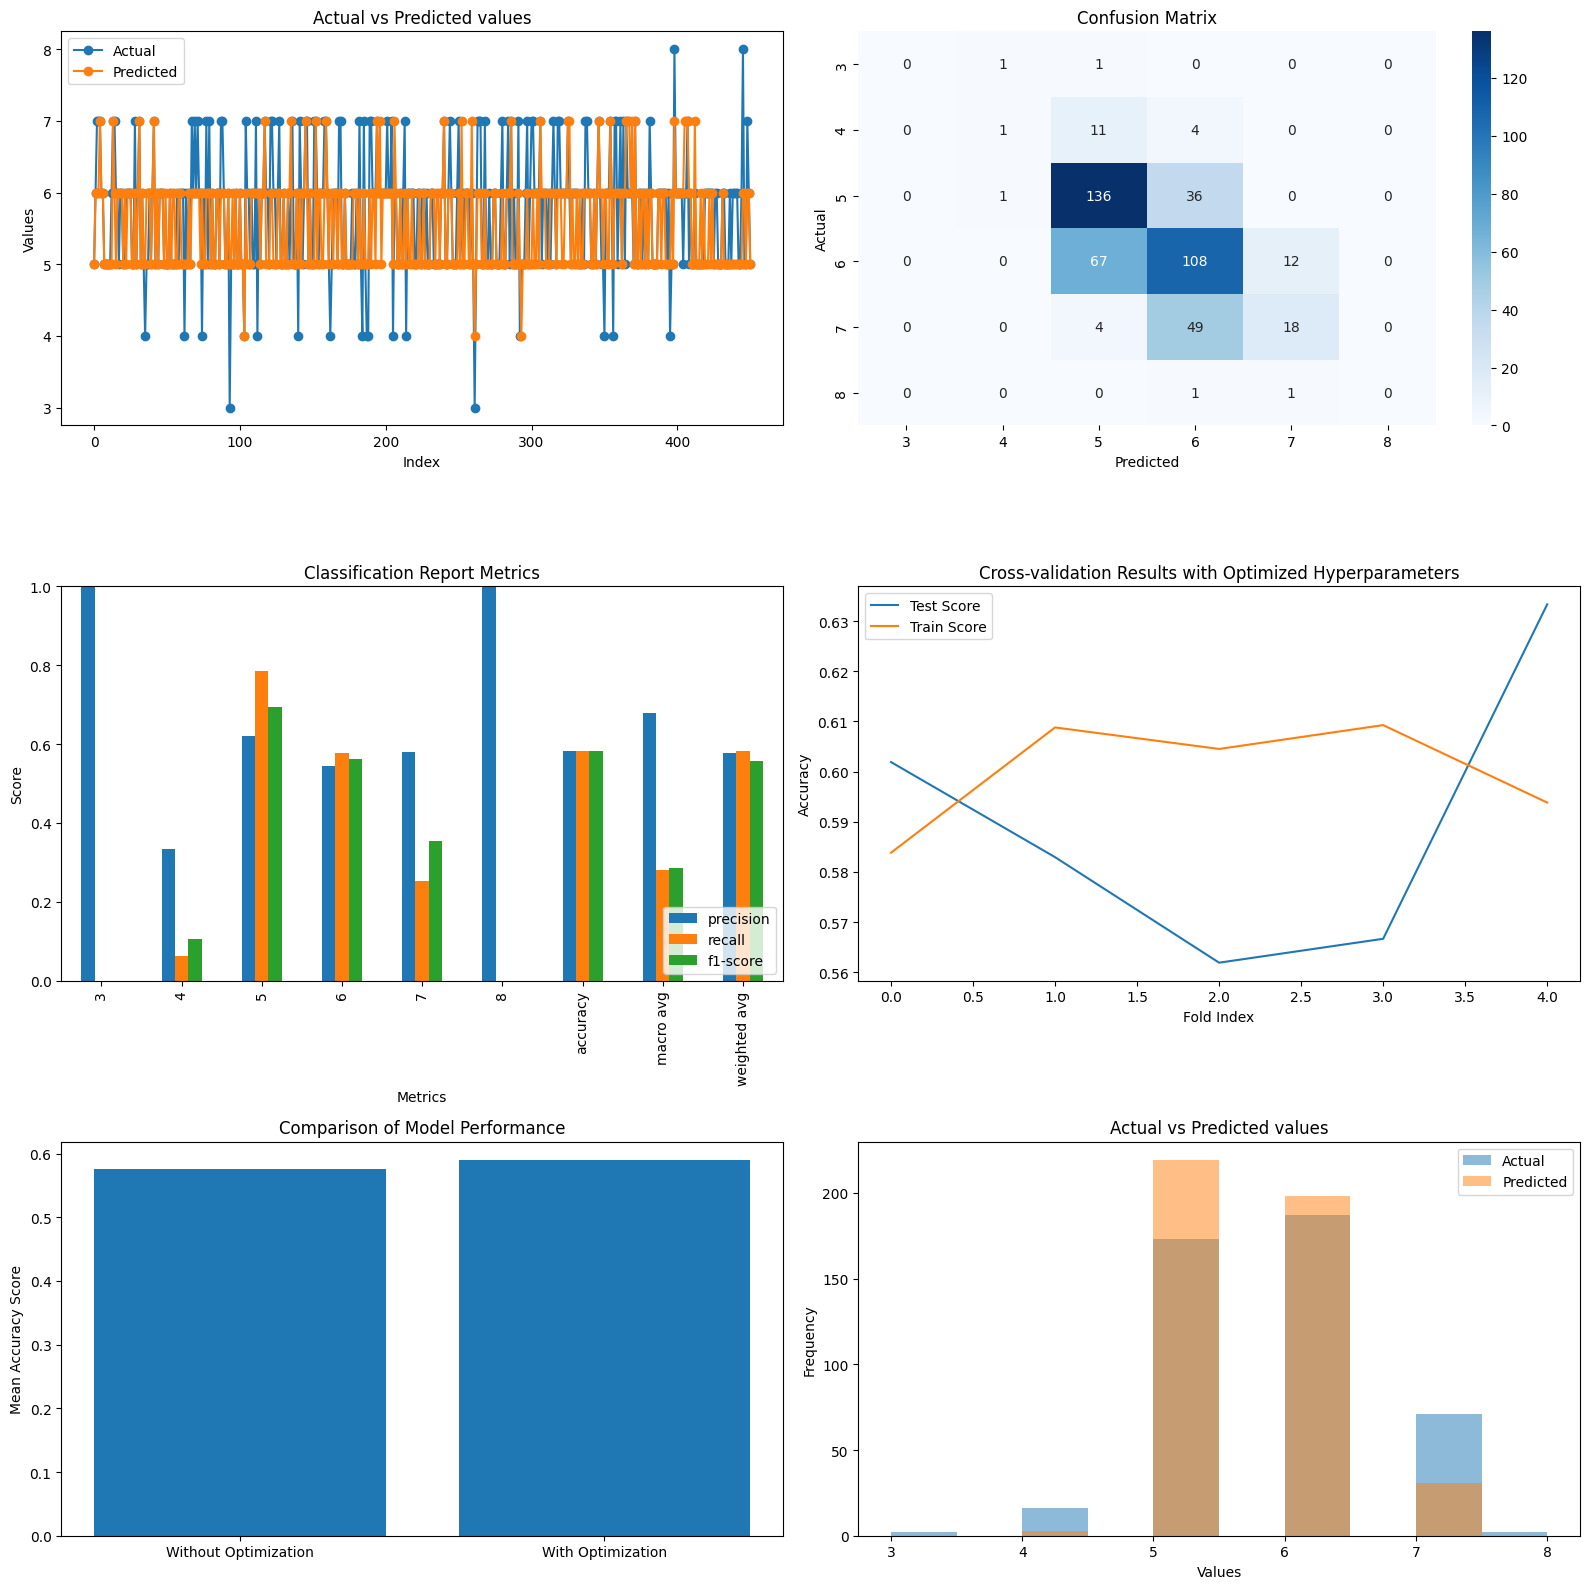

In [10]:

def gaussian_naive_bayes_main():
    try:
        
        #Podział danych na zbior testowy i treningowy
        X_train, X_test, y_train, y_test = initialize_and_split_data("standard", 'none')
        logging.info("Data initialization and splitting complete.")

        #Utworzenie obiektu modelu
        X_train_scaled, X_test_scaled = scale_data(X_train, X_test)

        #Utworzenie obiektu modelu
        gnb = GaussianNB()

        #Wytrenowanie i wstepna ocena modelu
        mean_accuracy, X_fold_test, y_fold_test, y_pred, accuracy_scores = evaluate_model(X_train_scaled, y_train, gnb)
        accuracy_without_optimization = mean_accuracy

        #Hiperparametryzacja
        best_params = optimize_hyperparameters(X_train_scaled, y_train, gnb)

        #Walidacja krzyżowa modelu ze zoptymalizowanymi hiperparametrami
        cv_results = cross_validation_with_optimized_hyperparameters(X_train_scaled, y_train, gnb, best_params)
        accuracy_with_optimization = np.mean(cv_results['test_score'])

        #Ponowne wyktrenowanie modelu, ale ze zoptymalizowanymi hiperparametrami
        gnb.set_params(**best_params)
        gnb.fit(X_train_scaled, y_train)

        #Predykcje na zbiorze testowym
        y_pred_optimized = gnb.predict(X_test_scaled)

        #Generacja raportu dla modelul
        report_optimized = generate_report(y_test, y_pred_optimized)

        #Generacja wykresów dla modelu
        display_plots(y_test, y_pred_optimized, report_optimized, cv_results, accuracy_without_optimization, accuracy_with_optimization)

    except Exception as e:
        logging.error("An error occurred during model evaluation and plotting.", exc_info=True)

if __name__ == "__main__":
    gaussian_naive_bayes_main()

### 6. Podsumowanie

Model uzyskuje słabe wyniki, jego dokładność po hiperparametryzacji, której wpływ widac w wynikach modelu, wynosi jedynie 58%. Jest on marginalnie lepszy od modelu KNN. Co ciekawe, był w stanie z dużą skutecznością wychwycić przedstawicieli klas o niskiej reprezentacji z zbiorze danych.